In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import Efficient_Fronter as ef

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

import pandas_datareader.data as pdr
from datetime import datetime, timedelta

plt.style.use('fivethirtyeight')
np.random.seed(888)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/shawn/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In this report, we will discuss about the two methods of stock portfolio building and how to build a portfolio of assets. Some statistic will be discussed in the report. 
The first method we are going explore is time-series method on stock predict. Then, use the prediction to build our portfolio. 

## Data Sources

In [3]:
stocks = ['DRYS','OTIC','AAPL','AMZN', 'GOOGL','FB','INPX']
end = datetime.now().date()
start = end - timedelta(days = 600)

stock_prices = pdr.get_data_yahoo(stocks, start, end)['Adj Close']
stock_prices_wt_dtcol = stock_prices.reset_index()

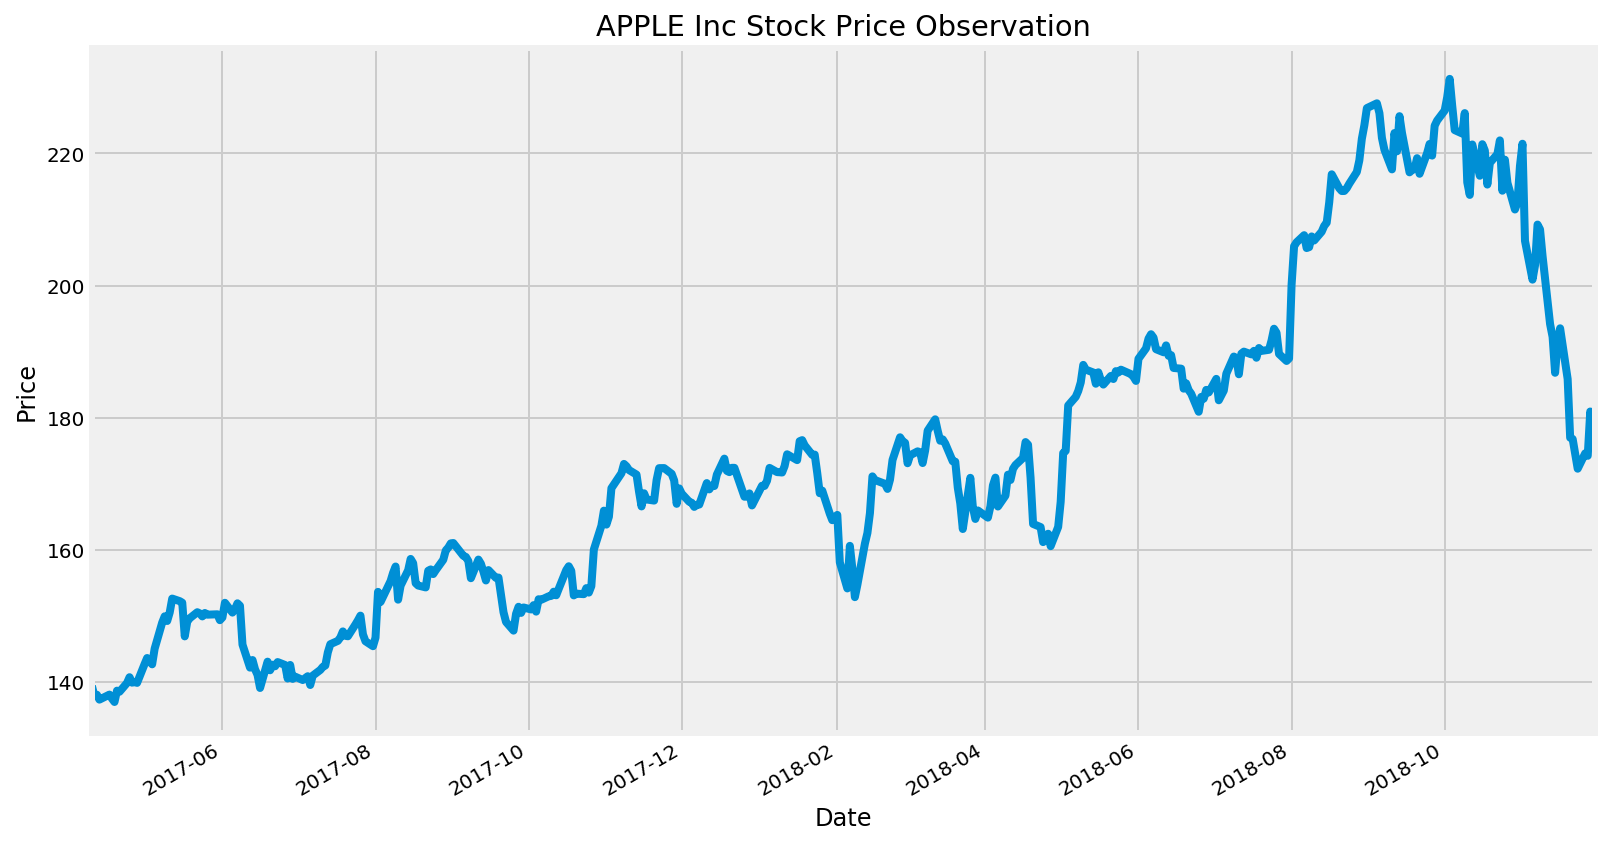

In [6]:
plt.figure(figsize=(12,7))
plt.title("APPLE Inc Stock Price Observation")
plt.xlabel('Date')
plt.ylabel('Price')
stock_prices['AAPL'].plot()

## AR model on Stock Pricing 

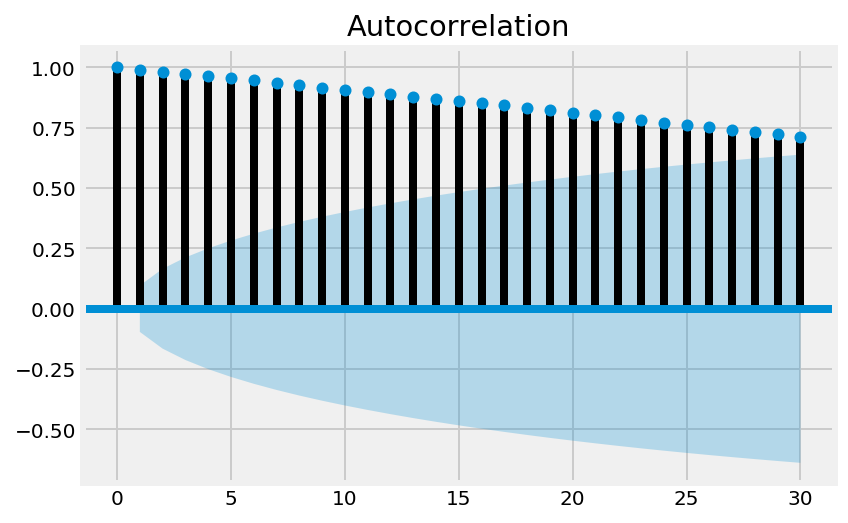

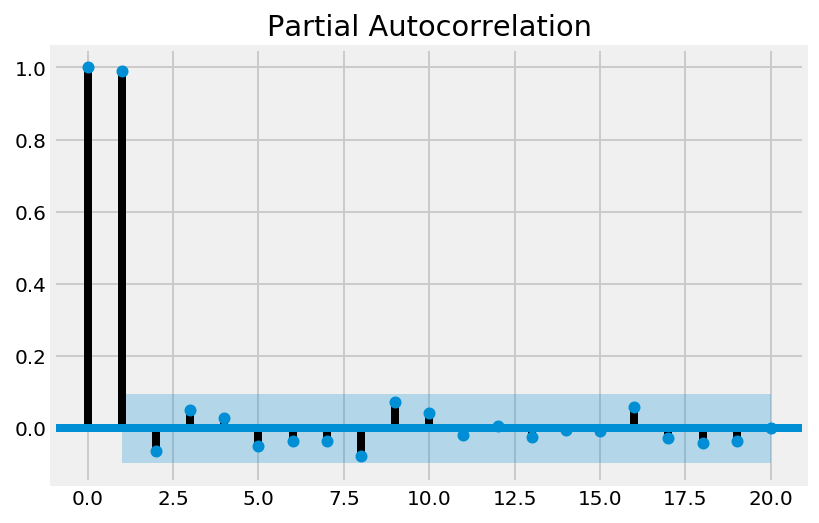

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
data = stock_prices['AAPL']
data = data.to_frame()

plot_acf(data,lags=30)
plt.show()

plot_pacf(data,lags=20)
plt.show()

In [357]:
for stk_nm in stock_prices.columns:
    data = stock_prices[stk_nm]
    data = data.to_frame()
    print("Analysis on " + stk_nm)
    # Calculate autocorrelation and partial-ac 
    ac_result = [i for i,x in enumerate(acf(stock_prices[stk_nm]) > 0.8) if x]
    pac_result =[i for i,x in enumerate(abs(pacf(stock_prices[stk_nm])) > 0.1) if x]

    if len(ac_result) > len(pac_result):
        max_num_vars = len(pac_result)
        result = pac_result
        l_result = ac_result
    else:
        max_num_vars = len(ac_result)
        result = ac_result
        l_result = pac_result

    # Use the ac and pac to choose correlated time series variable
    # Expand the dataset for timeseries variable 
    for i in range(max_num_vars):
        if result[i]!= 0 and result[i] in l_result:
            new_col_name = str(result[i]) +"_shift"
            data[new_col_name] = data[stk_nm].shift(result[i])
            data = data.dropna()

    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    
    # Fit the model and calculate the MSE
    num_row = len(data)
    x_train, y_train = data.iloc[:,1:].iloc[:int(num_row*0.9)],data[stk_nm].iloc[:int(num_row*0.9)]
    x_test, y_test = data.iloc[:,1:].iloc[int(num_row*0.9):],data[stk_nm].iloc[int(num_row*0.9):]
    LR = linear_model.LinearRegression()
    LR.fit(x_train,y_train)
    pred_y_test = LR.predict(x_test)

    # The coefficients
    print('Coefficients: \n', LR.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_test.iloc[1:], pred_y_test[:-1]))

    pred_y_test_df = pd.Series(data=pred_y_test[:-1], index=y_test.iloc[1:].index)
    # Calculate percentage error
    mean_perc_err = ((y_test.iloc[1:] - pred_y_test_df.iloc[:-1]) / y_test.iloc[1:]).mean()

Analysis on AAPL
Coefficients: 
 [ 1.00103267]
Mean squared error: 19.02
Analysis on AMZN
Coefficients: 
 [ 0.96685264  0.06828577 -0.03360269]
Mean squared error: 2568.06
Analysis on DRYS
Coefficients: 
 [ 1.13037949 -0.20212807 -0.14045766  0.16561946]
Mean squared error: 0.07
Analysis on FB
Coefficients: 
 [ 0.97647814]
Mean squared error: 13.79
Analysis on GOOGL
Coefficients: 
 [ 1.0657085  -0.14997412  0.07557834]
Mean squared error: 513.93
Analysis on INPX
Coefficients: 
 [ 0.5266146   0.39234089 -0.22096699  0.06219857  0.16532873  0.03596997]
Mean squared error: 0.00
Analysis on OTIC
Coefficients: 
 [ 0.97723167  0.00934835]
Mean squared error: 0.02


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.23


Symbols     AAPL   AMZN  DRYS     FB  GOOGL  INPX  OTIC
allocation  1.97  37.89  0.56  26.25  32.64  0.16  0.52
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.07
Annualised Volatility: 0.22


Symbols      AAPL  AMZN  DRYS     FB  GOOGL  INPX  OTIC
allocation  33.39  9.66  3.41  29.17  21.11  0.85  2.41


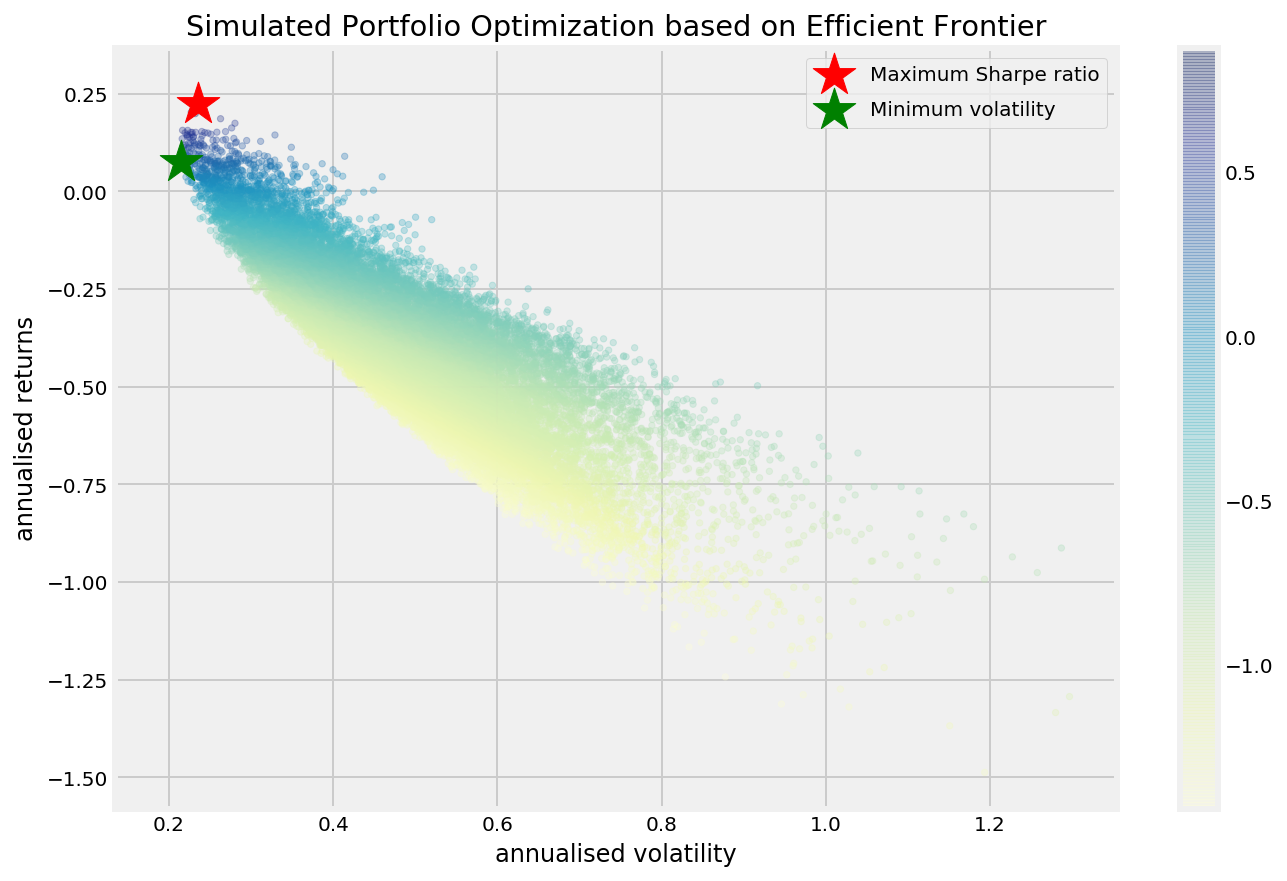

In [8]:
ef.cal_plot_efficient_fronter(table=stock_prices,num_portfolios=25000, risk_free_rate=0.0178)

# Momentum Capture Methond

Text(0,0.5,'Stock Price ($)')

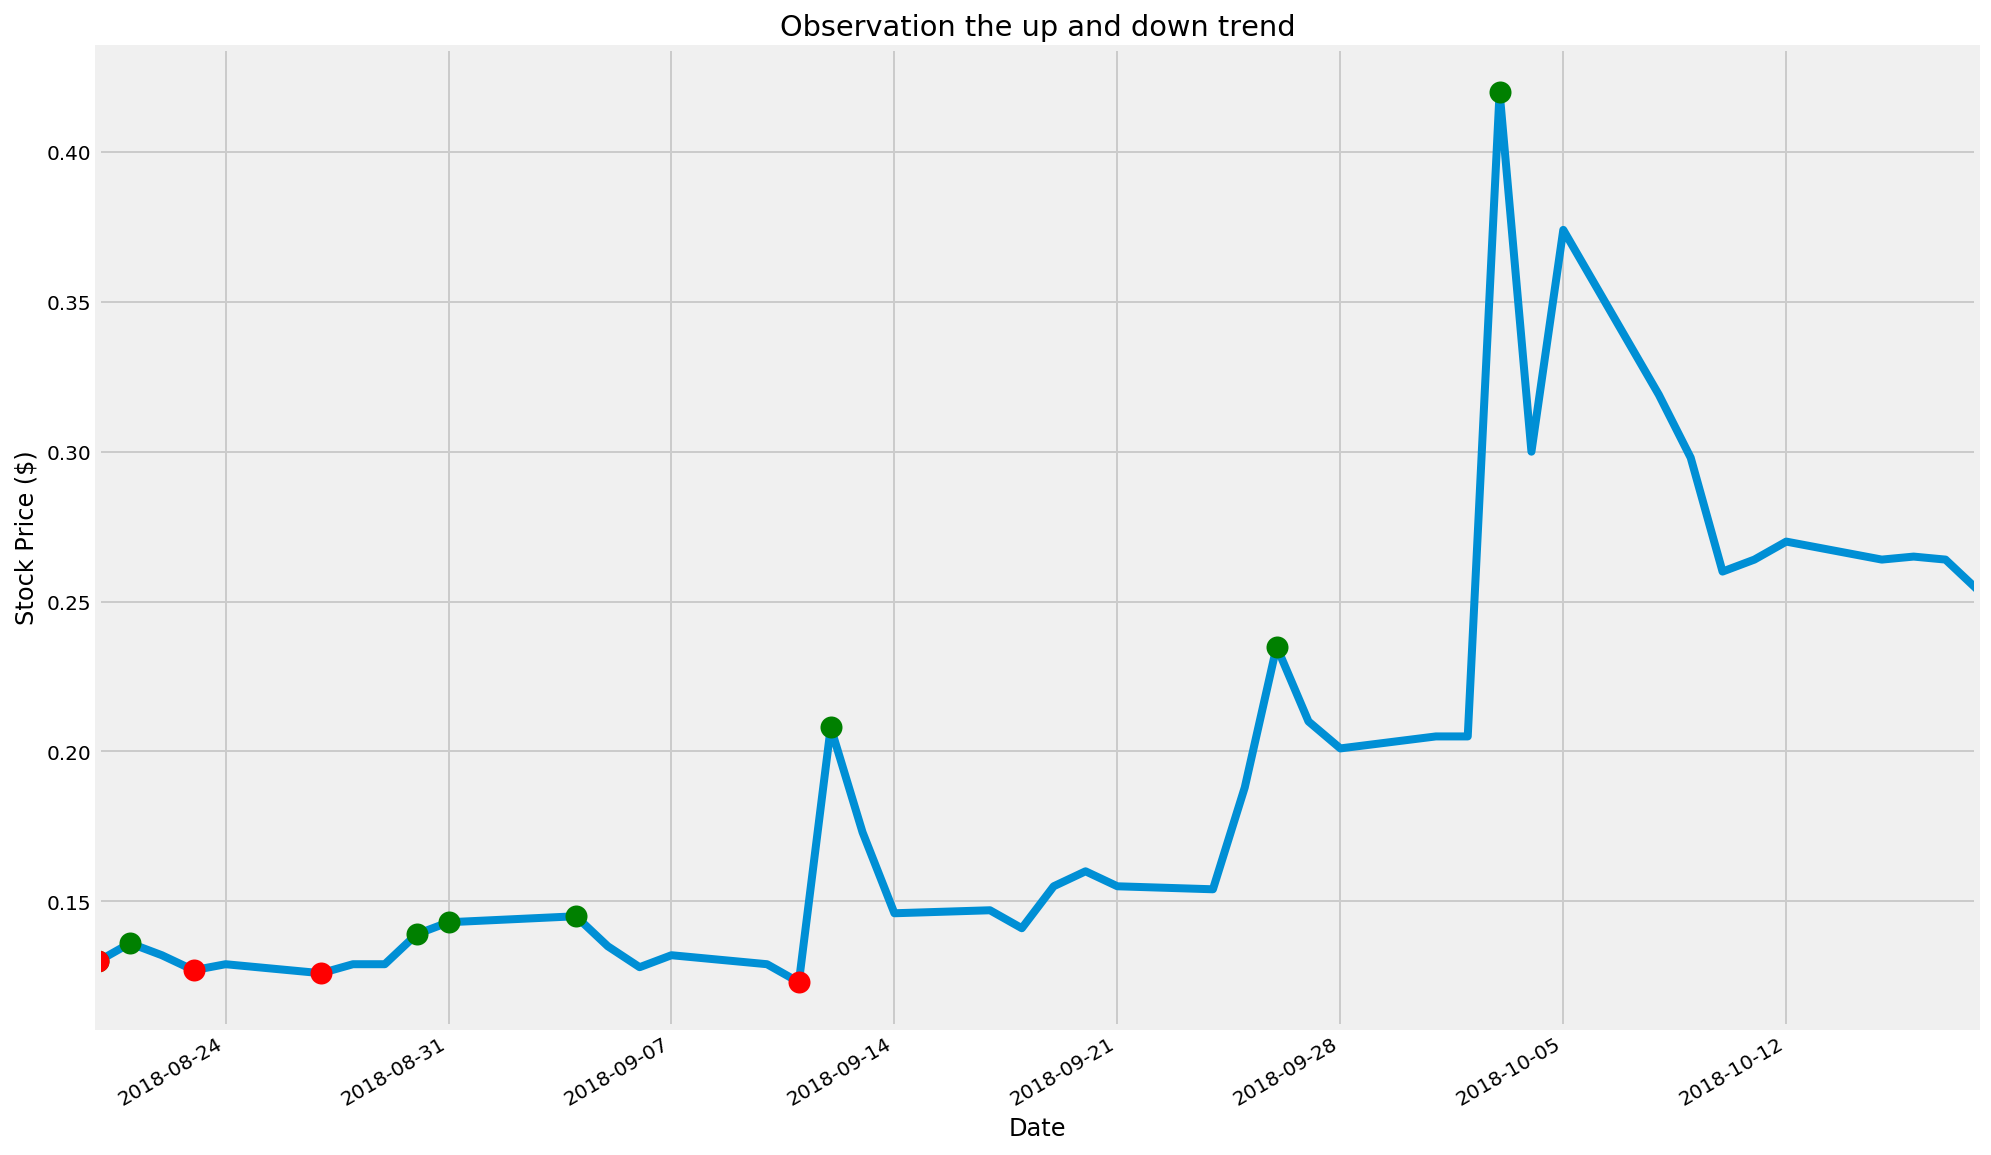

In [449]:
# stocks = ['DRYS','OTIC','AAPL','AMZN', 'GOOGL','FB','INPX']
stocks = ['INPX']
end = datetime.now().date()
start = end - timedelta(days = 60)
stock_prices = pdr.get_data_yahoo(stocks, start, end)['Adj Close']
stock_prices_wt_dtcol = stock_prices.reset_index()

# stk_price = stock_prices['INPX']
# stk_price.cummax().groupby('INPX')
max_price = stock_prices.INPX.cummax().unique()
min_price = -(-stock_prices.INPX.cummin().unique())

stk_returns_change = stk_price.pct_change()
stk_returns_change = stk_returns_change
drop_draw = stk_returns_change.cummax() - stk_returns_change

plt.figure(figsize=(15,10))
stock_prices['INPX'].plot()
# stk_returns_change.plot(color = 'g')

for price in max_price:
    i = stock_prices.INPX[stock_prices.INPX == price].index
    j = stock_prices.INPX[stock_prices.INPX == price]
    plt.plot(i, j, 'o', markersize=10,color = 'green')
    
for price in min_price:
    i = stock_prices.INPX[stock_prices.INPX == price].index
    j = stock_prices.INPX[stock_prices.INPX == price]
    plt.plot(i, j, 'o', markersize=10,color = 'r')
    
plt.title("Observation the up and down trend")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")

# for i in range(len(max_price) - 1):
#     fomer_pt = stock_prices[stock_prices.INPX == max_price[i]].index
#     late_pt = stock_prices[stock_prices.INPX == max_price[i+1]].index
#     period_cut = stock_prices.INPX[stock_prices.index >= fomer_pt and stock_prices.index <= late_pt]
    
#     j = min_price = period_cut.min()
#     i = period_cut[period_cut == min_price].index
#     plt.plot(i, j, 'o', markersize=10,color = 'r')
    
# for dp_rank in range(3):
#     i = drop_draw.index[drop_draw.argsort().iloc[-dp_rank - 1]+1]
#     j = drop_draw.index[stk_returns_change.argsort()[-dp_rank -1]+1]

#     i_value = stk_price[stk_returns_change.index == i]
#     j_value = stk_price[stk_returns_change.index == j]
#     i_cha_value = stk_returns_change[stk_returns_change.index == i]
#     j_cha_value = stk_returns_change[stk_returns_change.index == j]

#     colors = ['red','yellow','blue']
#     plt.plot([i, j], [i_value, j_value], 'o', color=colors[dp_rank], markersize=10)

#     plt.plot([i, j], [i_cha_value, j_cha_value], 'o', color=colors[dp_rank], markersize=10)

In [27]:
# TODO Play session 
data = pd.read_csv("000660.csv")
data = data.iloc[:,0:2]
data.iloc[:,1] = data.iloc[:,1]/1000
data.iloc[:,1] = data.iloc[:,1].apply(lambda x:round(x,2))

In [32]:
ck_pt = data.iloc[0,1]
abs((data.iloc[:,1] - ck_pt)/ck_pt) > 0.1


0       False
1       False
2       False
3        True
4        True
5        True
6        True
7       False
8       False
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
        ...  
3359     True
3360     True
3361     True
3362     True
3363     True
3364     True
3365     True
3366     True
3367     True
3368     True
3369     True
3370     True
3371     True
3372     True
3373     True
3374     True
3375     True
3376     True
3377     True
3378     True
3379     True
3380     True
3381     True
3382     True
3383     True
3384     True
3385     True
3386     True
3387     True
3388     True
Name: 6405.0, Length: 3389, dtype: bool

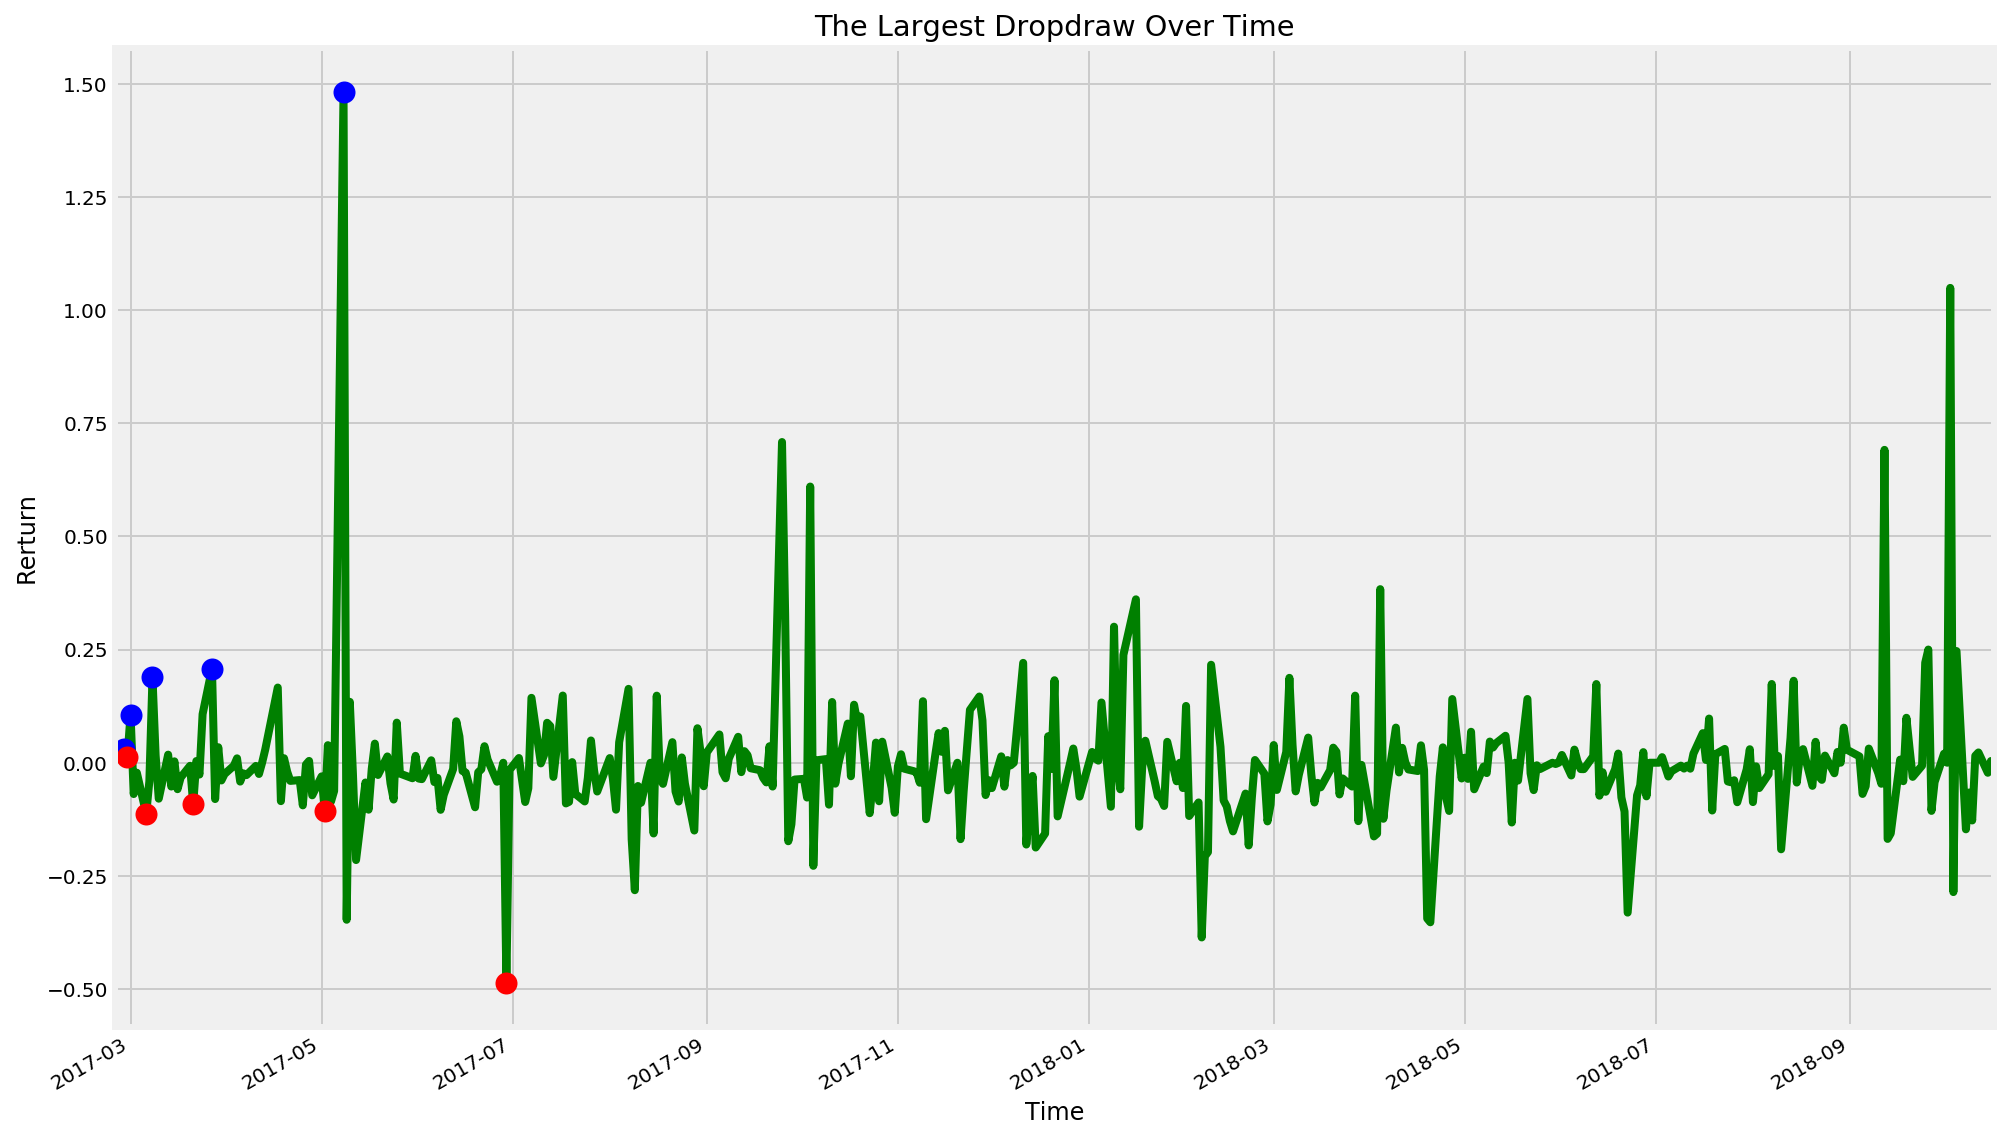

In [364]:
stk_price = stock_prices['INPX']
stk_returns_change = stk_price.pct_change() 
drop_draw = stk_returns_change.cummax() - stk_returns_change
up_pull = stk_returns_change - stk_returns_change.cummin() 

plt.figure(figsize=(15,10))
# stock_prices['INPX'].plot()
stk_returns_change.plot(color = 'g')
max_value = stk_returns_change.cummax().dropna()
cum_max_values = max_value.groupby(max_value).first()


# for i in range(len(cum_min_values)):
# #     x_val = drop_draw.dropna()[(-drop_draw).dropna().argsort() == i].index
# #     y_val = stk_returns_change[x_val].iloc[0]
# #     plt.plot(x_val, y_val, 'o', color='red', markersize=10)  
#     x_val = stk_returns_change[-stk_returns_change == cum_min_values.iloc[i]].index
#     y_val = stk_returns_change[-stk_returns_change == cum_min_values.iloc[i]]
#     plt.plot(x_val, y_val, 'o', color='red', markersize=10)
            
for i in range(len(cum_max_values)):
    if i != len(cum_max_values)-1:
        x_val = stk_returns_change[stk_returns_change == cum_max_values.iloc[i]].index
        x_val_nt = stk_returns_change[stk_returns_change == cum_max_values.iloc[i+1]].index
    else:
        x_val = stk_returns_change[stk_returns_change == cum_max_values.iloc[i]].index
        x_val_nt = stk_returns_change[stk_returns_change == stk_returns_change.iloc[-1]].index
    
    windows = stk_returns_change[stk_returns_change.index.to_series().apply(lambda x:x > x_val and x < x_val_nt).apply(lambda x:x[0])]
    windows_min_return = windows.min()
    windows_min_date = windows[windows == windows_min_return].index

        
    y_val = cum_max_values.iloc[i]
    plt.plot(x_val, y_val, 'o', color='blue', markersize=10)
    plt.title('The Largest Dropdraw Over Time')
    plt.ylabel('Rerturn')
    plt.xlabel('Time')
    plt.plot(windows_min_date, windows_min_return, 'o', color='red', markersize=10)
#     plt.plot(windows_min_date,stock_prices['INPX'][windows_min_date][0],'o', color='black', markersize=10)